When a medical claim is submitted, the insurance provider must process the claim to determine the correct financial responsibility of the insurance provider and the patient. The process to determine this is broadly known as claims adjudication. It involves creating a claims processing workflow that checks each claim for authenticity, correctness, and validity based on coverage. Some of the steps in this workflow involve working with unstructured data (data that is not represented as rows and columns) which requires manual steps in the workflow to extract the information buried in the unstructured notes. According to the 2018 CAHQ index report, there were approximately 6.1 billion medical claims submitted in 2018, which represents a 4 percent increase in the volume from 2017, and it’s expected to continue rising in subsequent years. To process such volumes in a cost effective and scalable manner, healthcare payers are increasingly looking at machine learning to reduce dependency on humans and rely on automation as much as possible. Additionally, analyzing and interpreting health claim data is powerful in driving improvements in population health to address issues related to cost, quality and outcomes. According to the CDC report analyzing claim documents will help identify certain behaviors that would help in preventing or delaying the development of a medical condition. Healthcare is a data intense industry, and customers are looking for ways to automate and analyze these data.

In [3]:
import boto3
import json
import boto3
import re
import csv
import sagemaker
from sagemaker import get_execution_role
from sagemaker.s3 import S3Uploader, S3Downloader
import uuid
import time
import io
from io import BytesIO
import sys
from pprint import pprint

from IPython.display import Image, display
from PIL import Image as PImage, ImageDraw

In [4]:
!pip install amazon-textract-response-parser

In [5]:
role = get_execution_role()
#print("RoleArn: {}".format(role))

sess = sagemaker.Session()
bucket = sess.default_bucket()
prefix = 'claims-process-textract'

### Unified Residential Loan Application (URLA1003) formPaystubW2 formBank statementCredit card statementMortgage NotePassport1099 INT form1099 DIV form1099 MISC form1099 R formEmployment verification letterMortgage Statement

In [7]:
# Document

documentName = "URLA-1003.pdf"

client = boto3.client(service_name='textract',
         region_name= 'us-east-1',
         endpoint_url='https://textract.us-east-1.amazonaws.com')
# process using image bytes
def calltextract(documentName): 

    with open(documentName, 'rb') as file:
            img_test = file.read()
            bytes_test = bytearray(img_test)
            print('Image loaded', documentName)

    # process using image bytes
    response = client.analyze_document(Document={'Bytes': bytes_test}, FeatureTypes=['FORMS'])

    return response

In [10]:
response= calltextract(documentName)
print(response)

Image loaded URLA-1003.pdf
{'DocumentMetadata': {'Pages': 1}, 'Blocks': [{'BlockType': 'PAGE', 'Geometry': {'BoundingBox': {'Width': 1.0, 'Height': 1.0, 'Left': 0.0, 'Top': 0.0}, 'Polygon': [{'X': 0.0, 'Y': 2.3413836913732666e-07}, {'X': 1.0, 'Y': 0.0}, {'X': 1.0, 'Y': 1.0}, {'X': 4.185015995972208e-07, 'Y': 1.0}]}, 'Id': 'f724a516-178c-4247-aabd-0a2d0d2d5a9f', 'Relationships': [{'Type': 'CHILD', 'Ids': ['b814c5cc-3c87-43e9-a04b-a2a3407e20f4', '9f1b08c3-df9f-479d-bec9-32ddcea0c095', '406361d9-51b9-4989-867e-eadc5d7afe4a', 'a15cd582-cbe1-4b4d-9ec4-8683f850b425', '06d99f01-2187-46c9-90ec-e5aab3582930', 'c5f1b5ac-b8a3-4aa3-90b7-4a530e3edec3', '265f332d-5fc9-44cd-8d41-274448fed14c', 'cab98dd5-41c9-4c33-8b87-850f3efe6c50', 'c2798606-0a0d-4064-8b52-bc955fce8721', '92f7006f-f43e-4094-ac0a-80ef22d46b16', '685547aa-73ce-46c5-86e0-e6537a20b09c', '5893365c-752f-4d43-ba11-5f29b28a4135', 'e66581ff-ab1b-4bd0-a4d5-5bc797971044', '7213668e-6817-4e7c-a994-542599253bdd', '3107c5ef-a5c1-4d0e-a46a-04fb590

In [12]:
#Extract key values
# Iterate over elements in the document
from trp import Document
def getformkeyvalue(response):
    doc = Document(response)
    
    key_map = {}
    for page in doc.pages:
        # Print fields
        for field in page.form.fields:
            if field is None or field.key is None or field.value is None:
                continue
        
            key_map[field.key.text] = field.value.text
    return key_map

In [13]:
get_form_keys = getformkeyvalue(response)
print(get_form_keys)

{'Refinance': 'NOT_SELECTED', 'Purchase': 'SELECTED', 'Construction-Permanent': 'NOT_SELECTED', 'Secondary Residence': 'NOT_SELECTED', 'FHA': 'NOT_SELECTED', 'Unmarried (includes single, divorced, widowed)': 'NOT_SELECTED', 'Construction': 'NOT_SELECTED', 'Fee Simple': 'SELECTED', 'USDA/Rural Housing Service': 'NOT_SELECTED', 'Conventional': 'SELECTED', 'made': 'NOT_SELECTED', 'Fixed Rate': 'SELECTED', 'to be made': 'NOT_SELECTED', "Borrower's Name (include Jr. or Sr. if applicable)": 'Alejandro Rosalez', 'Agency Case Number': '8562057552458', 'VA': 'NOT_SELECTED', 'Total (a+b)': '$', 'Rent': 'NOT_SELECTED', 'Amount Existing Liens': '$', '(a) Present Value of Lot': '$', 'Home Phone (incl. area code)': '(888)555-0101', 'Lender Case Number': '58432890-8', 'Original Cost': '$', 'Subject Property Address (street, city, state, & ZIP)': '28777 Amos Lock, Markfurt, HI 71418', '(b) Cost of Improvements': '$', 'Social Security Number': '518-85-7136', 'DOB (mm/dd/yyyy)': '05/31/1982', 'Yrs. Scho

In [20]:
response = None
with open(documentName, 'rb') as document:
    imageBytes = bytearray(document.read())

    # Call Textract
    response = client.analyze_document(
        Document={'Bytes': imageBytes},
        # new QUERIES Feature Type for Textract Queries
        # We could add additional Feature Types like FORMS and/or TABLES
        # FeatureTypes=["QUERIES", "FORMS", "TABLS"],
        FeatureTypes=["QUERIES"],
        QueriesConfig={
            "Queries": [{
                "Text": "What is the prefered language?",
                "Alias": "LANGUAGE"
            }
        ]
        })
    print(response)

ParamValidationError: Parameter validation failed:
Unknown parameter in input: "QueriesConfig", must be one of: Document, FeatureTypes, HumanLoopConfig

#### Bank Statement

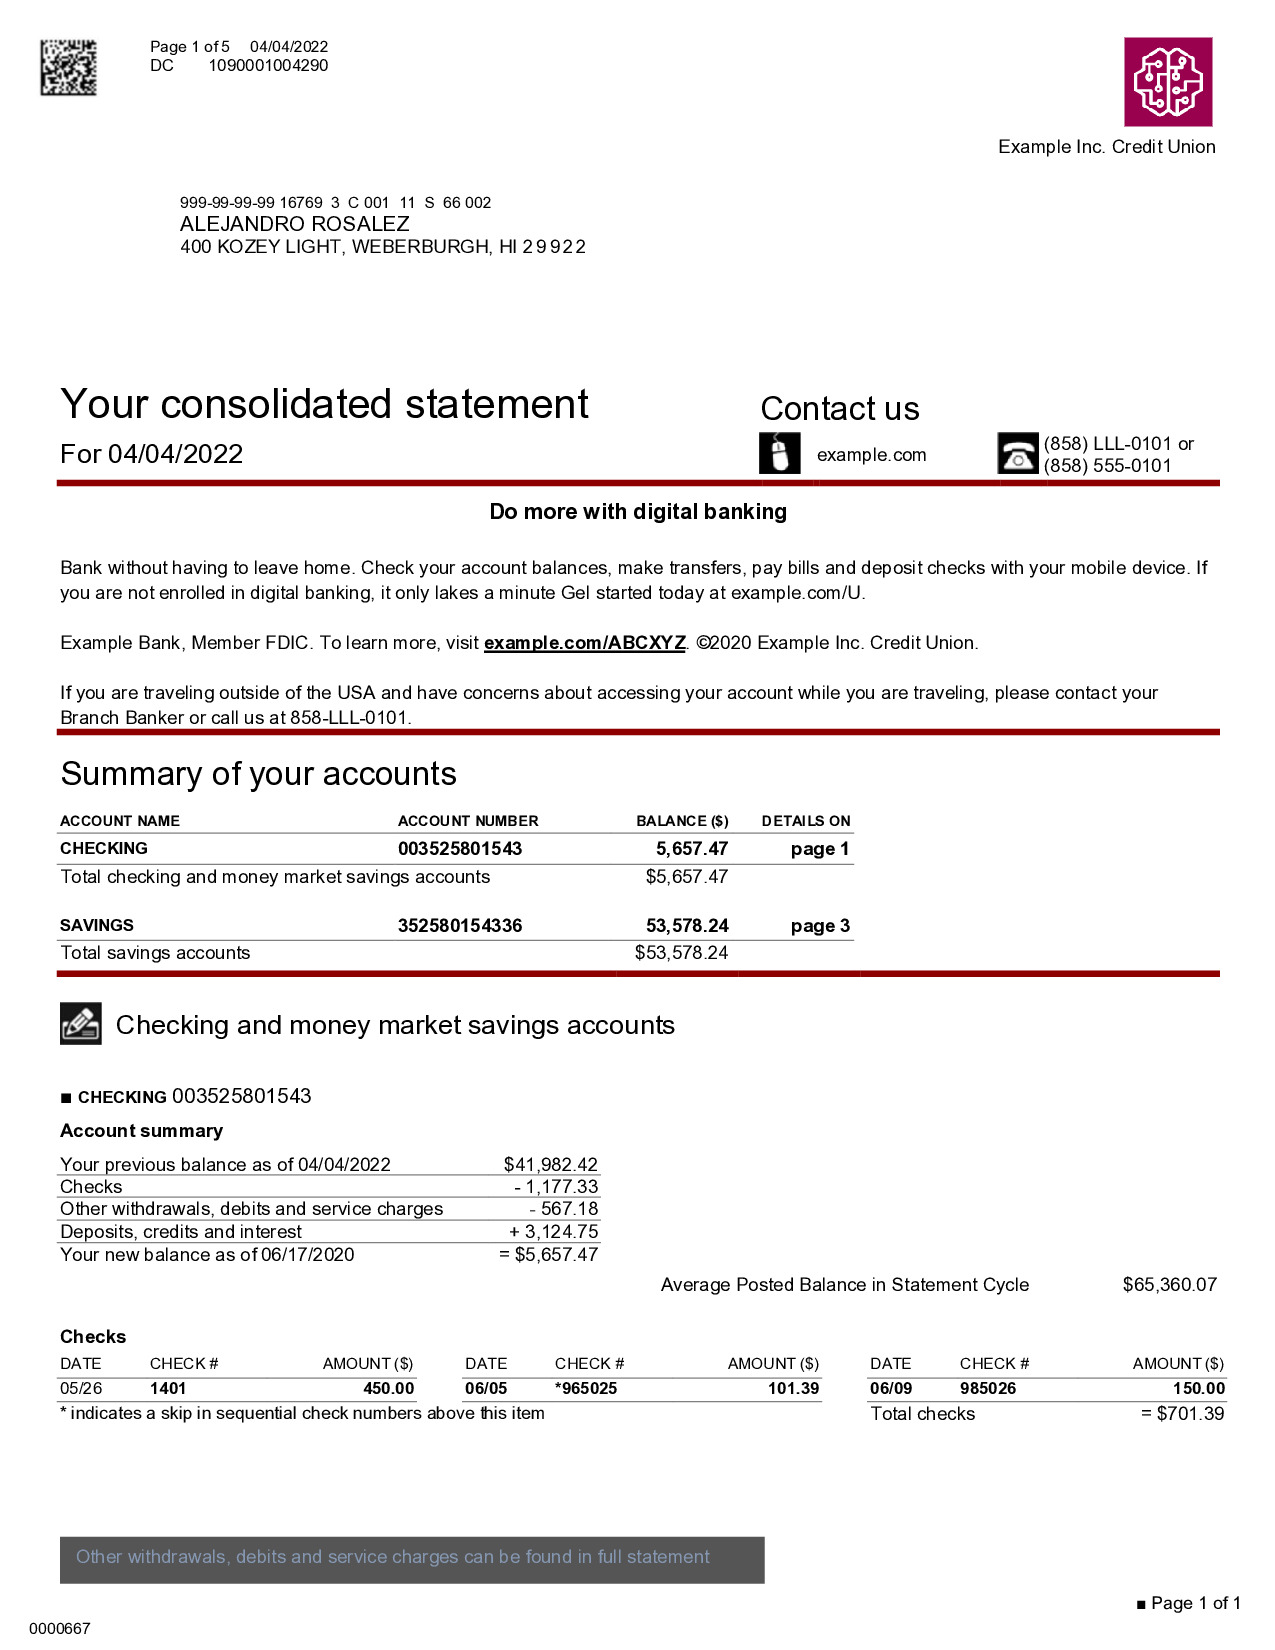

In [14]:
# Document

documentName = "Bank-Statement.jpg"

display(Image(filename=documentName))

In [16]:
response= calltextract(documentName)
#print(response)
get_form_keys = getformkeyvalue(response)
print(get_form_keys)

Image loaded Bank-Statement.jpg
{'Your new balance as of 06/17/2020': '= $5,657.47', 'Checks': '- 1,177.33', 'Deposits, credits and interest': '+ 3,124.75', 'Your previous balance as of 04/04/2022': '$41,982.42', 'Average Posted Balance in Statement Cycle': '$65,360.07', 'Other withdrawals, debits and service charges': '- 567.18', 'DATE': '06/09', 'CHECK #': '985026', 'AMOUNT ($)': '150.00', 'Total checks': '= $701.39', 'Example Inc.': 'Credit Union', 'DC': '1090001004290', 'CHECKING': '003525801543'}


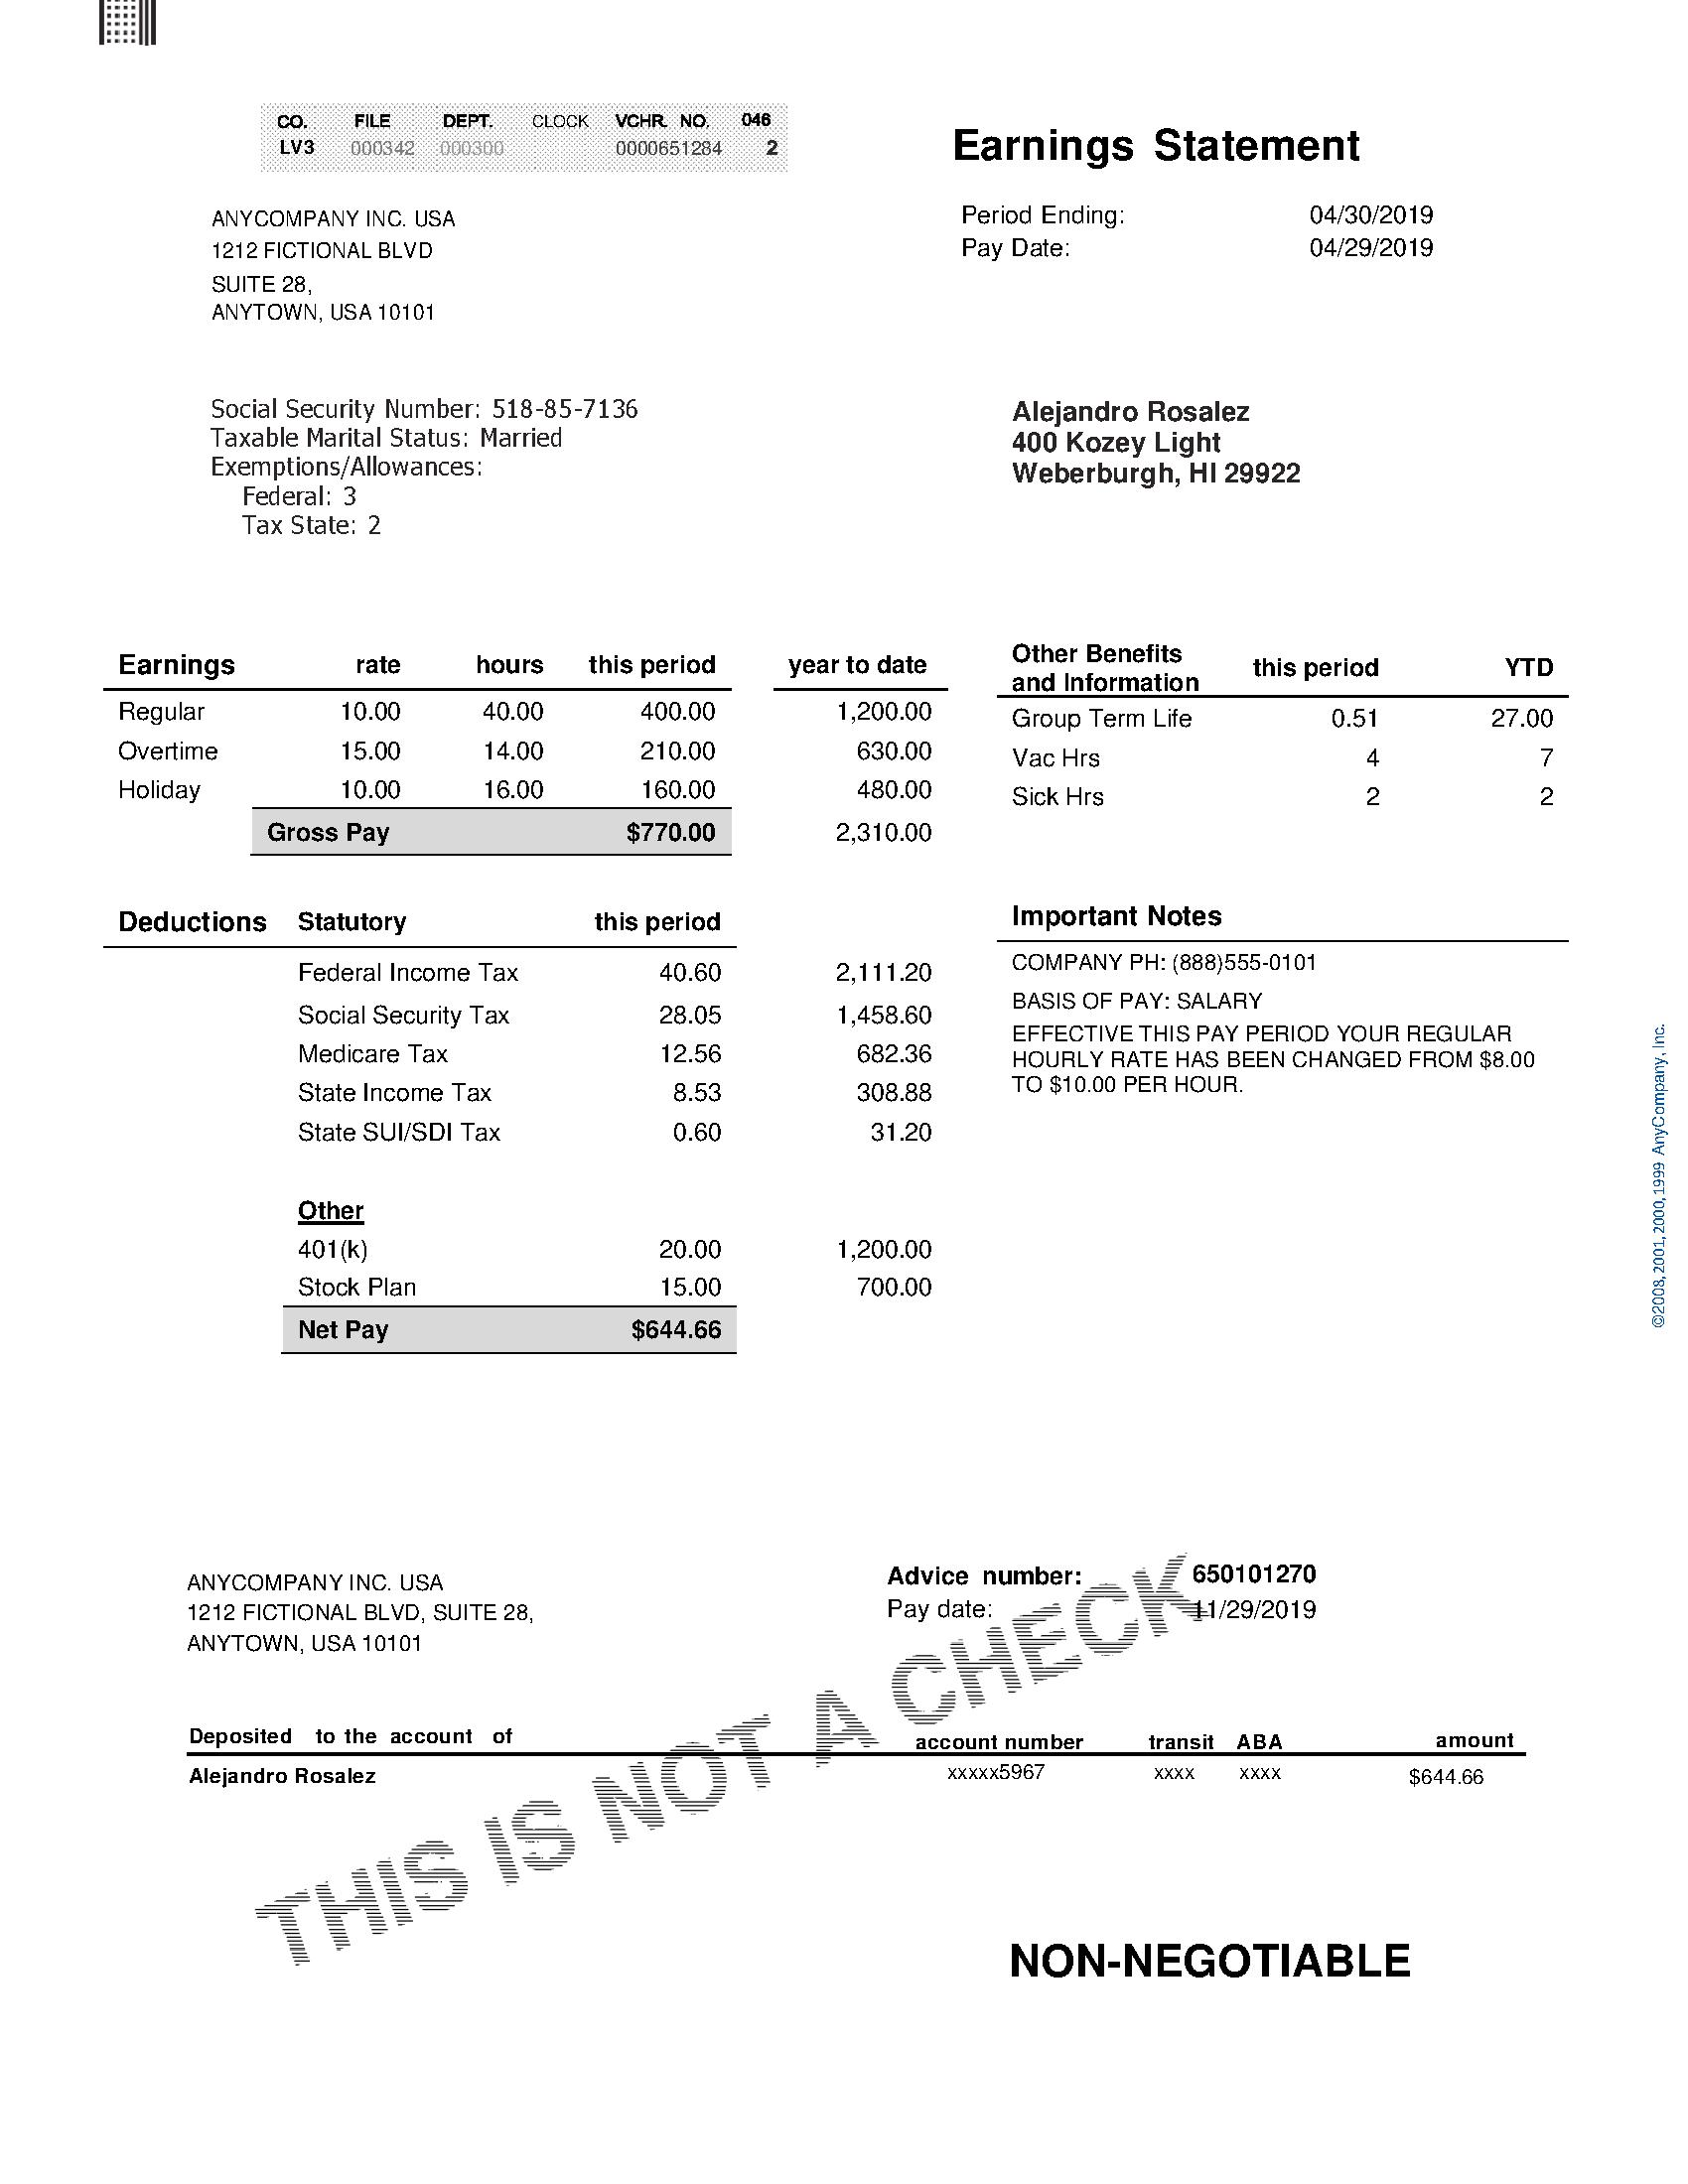

In [18]:
# Document

documentName = "Paystub.jpg"

display(Image(filename=documentName))

In [19]:
response= calltextract(documentName)

get_form_keys = getformkeyvalue(response)
print(get_form_keys)

Image loaded Paystub.jpg
{'Advice number:': '650101270', 'Pay date:': '11/29/2019', 'Pay Date:': '04/29/2019', 'account number': 'xxxxx5967', 'transit ABA': 'XXXX XXXX', 'Federal:': '3', 'Period Ending:': '04/30/2019', 'Social Security Number:': '518-85-7136', 'Tax State:': '2', 'amount': '$644.66', 'Taxable Marital Status:': 'Married', 'VCHR NO.': '0000651284', 'FILE': '000342', 'Deposited to the account of': 'Alejandro Rosalez', 'CO.': 'LV3', 'COMPANY PH:': '(888)555-0101', 'DEPT.': '000300', 'Net Pay': '$644.66', 'BASIS OF PAY:': 'SALARY', 'Gross Pay': '$770.00'}


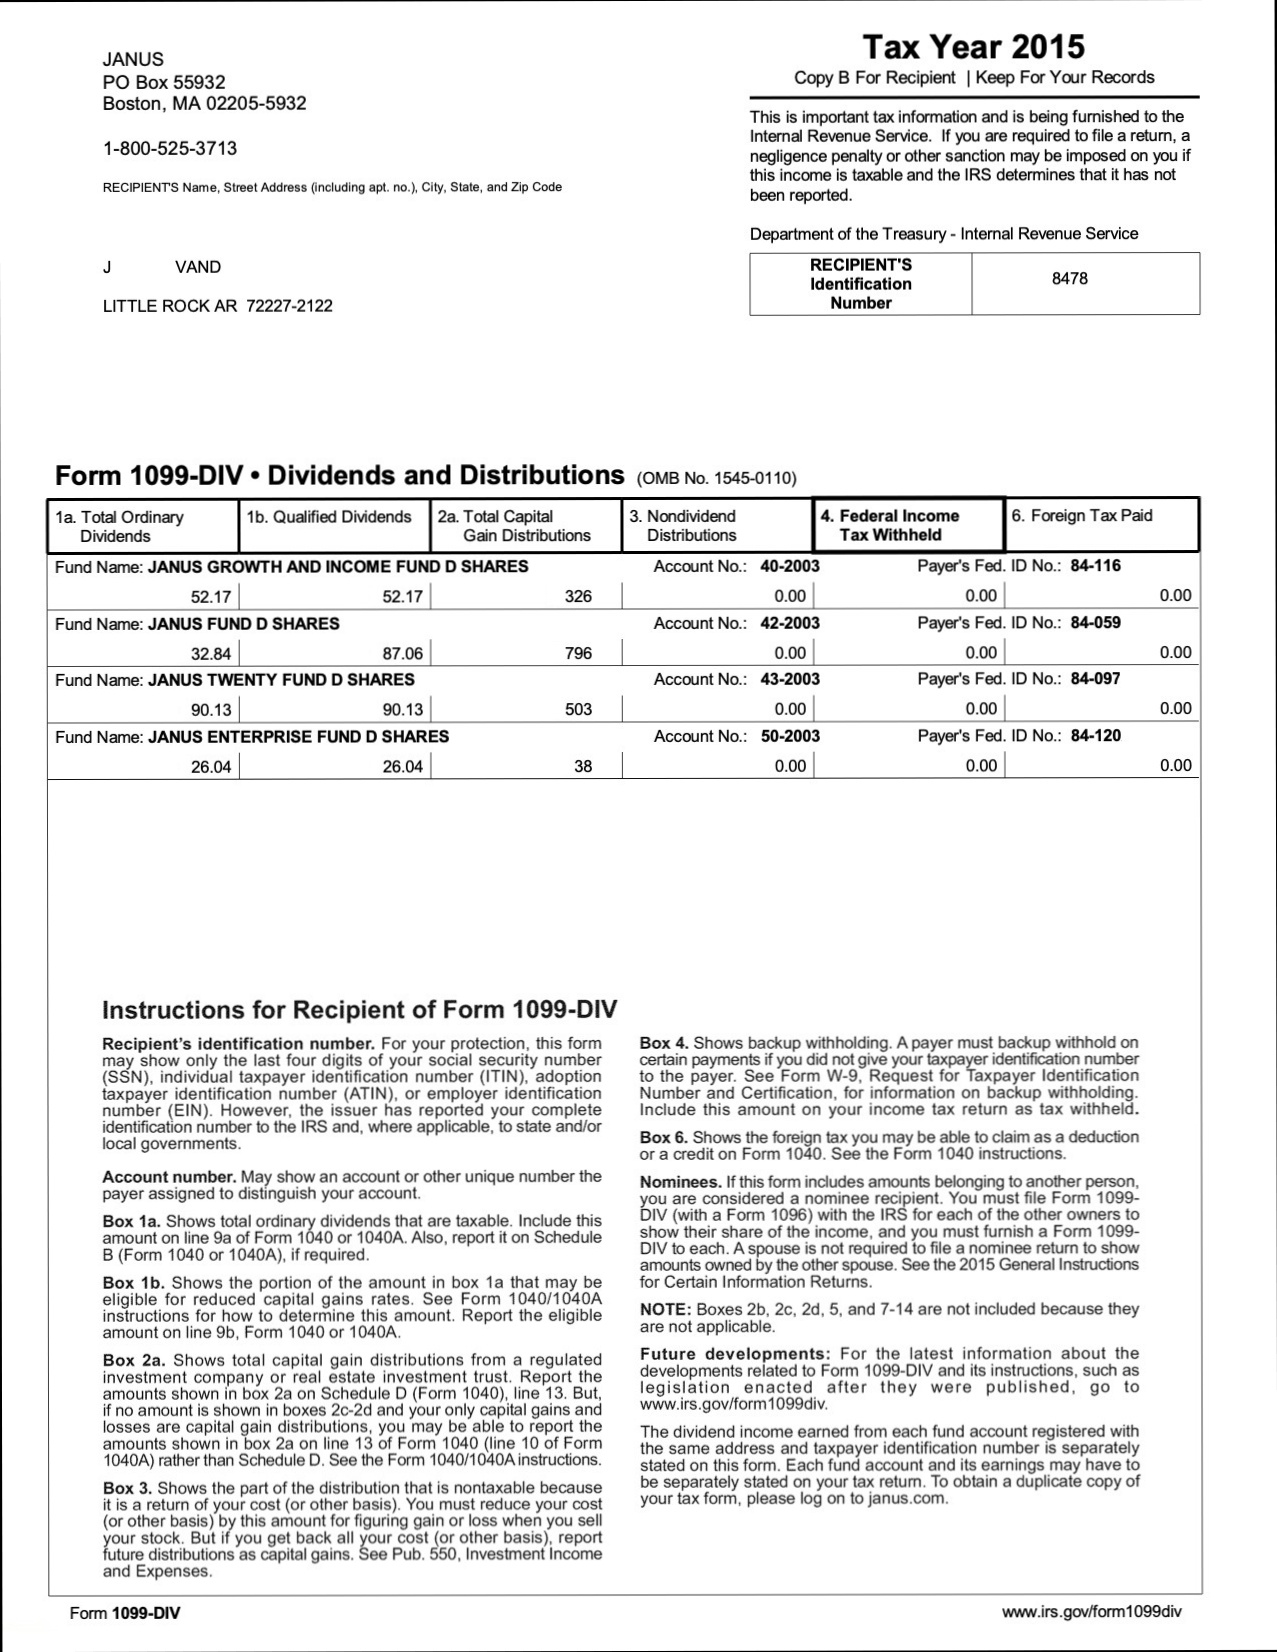

In [20]:
# Document

documentName = "1099-DIV.jpg"

display(Image(filename=documentName))

In [21]:
response= calltextract(documentName)

get_form_keys = getformkeyvalue(response)
print(get_form_keys)

Image loaded 1099-DIV.jpg
{'Account No.:': '40-2003', "Payer's Fed. ID No.:": '84-120', "RECIPIENT'S Identification Number": '8478', 'RECIPIENTS Name, Street Address (including apt. no.), City, State, and Zip Code': 'J VAND LITTLE ROCK AR 72227-2122', 'Fund Name:': 'JANUS ENTERPRISE FUND D SHARES'}


### Passport extraction with AnalyzeID

In [29]:
# Document

documentName = "Passport.pdf"

with open(documentName, 'rb') as document:
    imageBytes = bytearray(document.read())

response = client.analyze_id(
    DocumentPages=[{"Bytes":imageBytes}]
)

print(json.dumps(response, indent=2))

{
  "IdentityDocuments": [
    {
      "DocumentIndex": 1,
      "IdentityDocumentFields": [
        {
          "Type": {
            "Text": "FIRST_NAME"
          },
          "ValueDetection": {
            "Text": "ROSALEZ",
            "Confidence": 98.47076416015625
          }
        },
        {
          "Type": {
            "Text": "LAST_NAME"
          },
          "ValueDetection": {
            "Text": "ALEJANDRO",
            "Confidence": 99.00112915039062
          }
        },
        {
          "Type": {
            "Text": "MIDDLE_NAME"
          },
          "ValueDetection": {
            "Text": "",
            "Confidence": 99.68628692626953
          }
        },
        {
          "Type": {
            "Text": "SUFFIX"
          },
          "ValueDetection": {
            "Text": "",
            "Confidence": 99.65714263916016
          }
        },
        {
          "Type": {
            "Text": "CITY_IN_ADDRESS"
          },
          "ValueDetection"

### Extraction with Query

In [23]:
# Document

documentName = "Paystub.jpg"
response= calltextract(documentName)
response = None
with open(documentName, 'rb') as document:
    imageBytes = bytearray(document.read())

    # Call Textract
    response = client.analyze_document(
        Document={'Bytes': imageBytes},
        # new QUERIES Feature Type for Textract Queries
        # We could add additional Feature Types like FORMS and/or TABLES
        # FeatureTypes=["QUERIES", "FORMS", "TABLS"],
        FeatureTypes=["QUERIES"],
        QueriesConfig={
            "Queries": [{
                "Text": "What is the gross pay",
                "Alias": "GROSS_PAY"
            },
            {
                "Text": "What is the net pay?",
                "Alias": "NET_PAY"
            }
                
        ]
        })
    print(response)

Image loaded Paystub.jpg


ParamValidationError: Parameter validation failed:
Unknown parameter in input: "QueriesConfig", must be one of: Document, FeatureTypes, HumanLoopConfig

### Extraction with Comprehend

In [30]:
documentName = "Paystub.jpg"
response= calltextract(documentName)
print(response)

Image loaded Paystub.jpg
{'DocumentMetadata': {'Pages': 1}, 'Blocks': [{'BlockType': 'PAGE', 'Geometry': {'BoundingBox': {'Width': 1.0, 'Height': 1.0, 'Left': 0.0, 'Top': 0.0}, 'Polygon': [{'X': 0.0, 'Y': 0.0}, {'X': 1.0, 'Y': 0.00015229219570755959}, {'X': 1.0, 'Y': 1.0}, {'X': 1.635820154888279e-07, 'Y': 1.0}]}, 'Id': '1c8c95d1-839f-4ebd-9c8d-3befa0b45f88', 'Relationships': [{'Type': 'CHILD', 'Ids': ['6753e217-3566-4ff8-8e32-eb7d1b31e9cf', '7f299348-62ea-4d56-b37c-db135856a536', 'b6b3d85f-2599-4bb3-a736-ec68fb2346ed', '58024443-5601-4852-b749-656405565d77', '7a5672ab-7332-4f9e-aa4f-8e0957072e86', '6fa7329e-2265-4496-a19f-87f576827c1a', 'de85499c-ccaf-4862-a83d-a9f43dedec67', 'f2d43111-ad11-4b4a-91cf-0e56d24ef695', '5cfccb55-9427-4f6a-9b9c-e1dc42cbf1c8', 'd2bf7d58-ca01-40f5-915b-d6c1ef1eb3c3', '4bfdac2f-5058-4238-95df-6a52787e1118', '0dc894ea-f0c0-47fc-8a83-d8a758bab240', '51fd97bc-9ddf-4a79-8f69-9ad76530e5be', 'd673d76b-a573-4254-bba9-8887f3d0d328', '6e82d3eb-d8bb-4df1-a125-f32288b11

In [32]:
# Print detected text
text = ""       
for item in response["Blocks"]:
    if item["BlockType"] == "LINE":
        print ('\033[94m' +  item["Text"] + '\033[0m')
        text = text + " " + item["Text"]


CO.
FILE
DEPT.
CLOCK VCHR NO.
046
LV3
000342
000300
0000651284
2
Earnings Statement
ANYCOMPANY INC. USA
Period Ending:
04/30/2019
1212 FICTIONAL BLVD
Pay Date:
04/29/2019
SUITE 28,
ANYTOWN, USA 10101
Social Security Number: 518-85-7136
Alejandro Rosalez
Taxable Marital Status: Married
400 Kozey Light
Exemptions/Allowances:
Weberburgh, HI 29922
Federal: 3
Tax State: 2
hours
Other Benefits
Earnings
rate
this period
year to date
this period
YTD
and Information
Regular
10.00
40.00
400.00
1,200.00
Group Term Life
0.51
27.00
Overtime
15.00
14.00
210.00
630.00
Vac Hrs
4
7
Holiday
10.00
16.00
160.00
480.00
Sick Hrs
2
2
Gross Pay
$770.00
2,310.00
Deductions Statutory
this period
Important Notes
Federal Income Tax
40.60
2,111.20
COMPANY PH: (888)555-0101
BASIS OF PAY: SALARY
Social Security Tax
28.05
1,458.60
EFFECTIVE THIS PAY PERIOD YOUR REGULAR
Medicare Tax
12.56
682.36
HOURLY RATE HAS BEEN CHANGED FROM $8.00
State Income Tax
8.53
308.88
TO $10.00 PER HOUR.
State SUI/SDI Tax
0.60
31.20
Other


## Enrichment - Document Processing - PII Detection

In [37]:
documentName = "Paystub.jpg"
response= calltextract(documentName)
# Print detected text
text = ""       
for item in response["Blocks"]:
    if item["BlockType"] == "LINE":
        print ('\033[94m' +  item["Text"] + '\033[0m')
        text = text + " " + item["Text"]


Image loaded Paystub.jpg
CO.
FILE
DEPT.
CLOCK VCHR NO.
046
LV3
000342
000300
0000651284
2
Earnings Statement
ANYCOMPANY INC. USA
Period Ending:
04/30/2019
1212 FICTIONAL BLVD
Pay Date:
04/29/2019
SUITE 28,
ANYTOWN, USA 10101
Social Security Number: 518-85-7136
Alejandro Rosalez
Taxable Marital Status: Married
400 Kozey Light
Exemptions/Allowances:
Weberburgh, HI 29922
Federal: 3
Tax State: 2
hours
Other Benefits
Earnings
rate
this period
year to date
this period
YTD
and Information
Regular
10.00
40.00
400.00
1,200.00
Group Term Life
0.51
27.00
Overtime
15.00
14.00
210.00
630.00
Vac Hrs
4
7
Holiday
10.00
16.00
160.00
480.00
Sick Hrs
2
2
Gross Pay
$770.00
2,310.00
Deductions Statutory
this period
Important Notes
Federal Income Tax
40.60
2,111.20
COMPANY PH: (888)555-0101
BASIS OF PAY: SALARY
Social Security Tax
28.05
1,458.60
EFFECTIVE THIS PAY PERIOD YOUR REGULAR
Medicare Tax
12.56
682.36
HOURLY RATE HAS BEEN CHANGED FROM $8.00
State Income Tax
8.53
308.88
TO $10.00 PER HOUR.
State SUI/

### Claims Processing

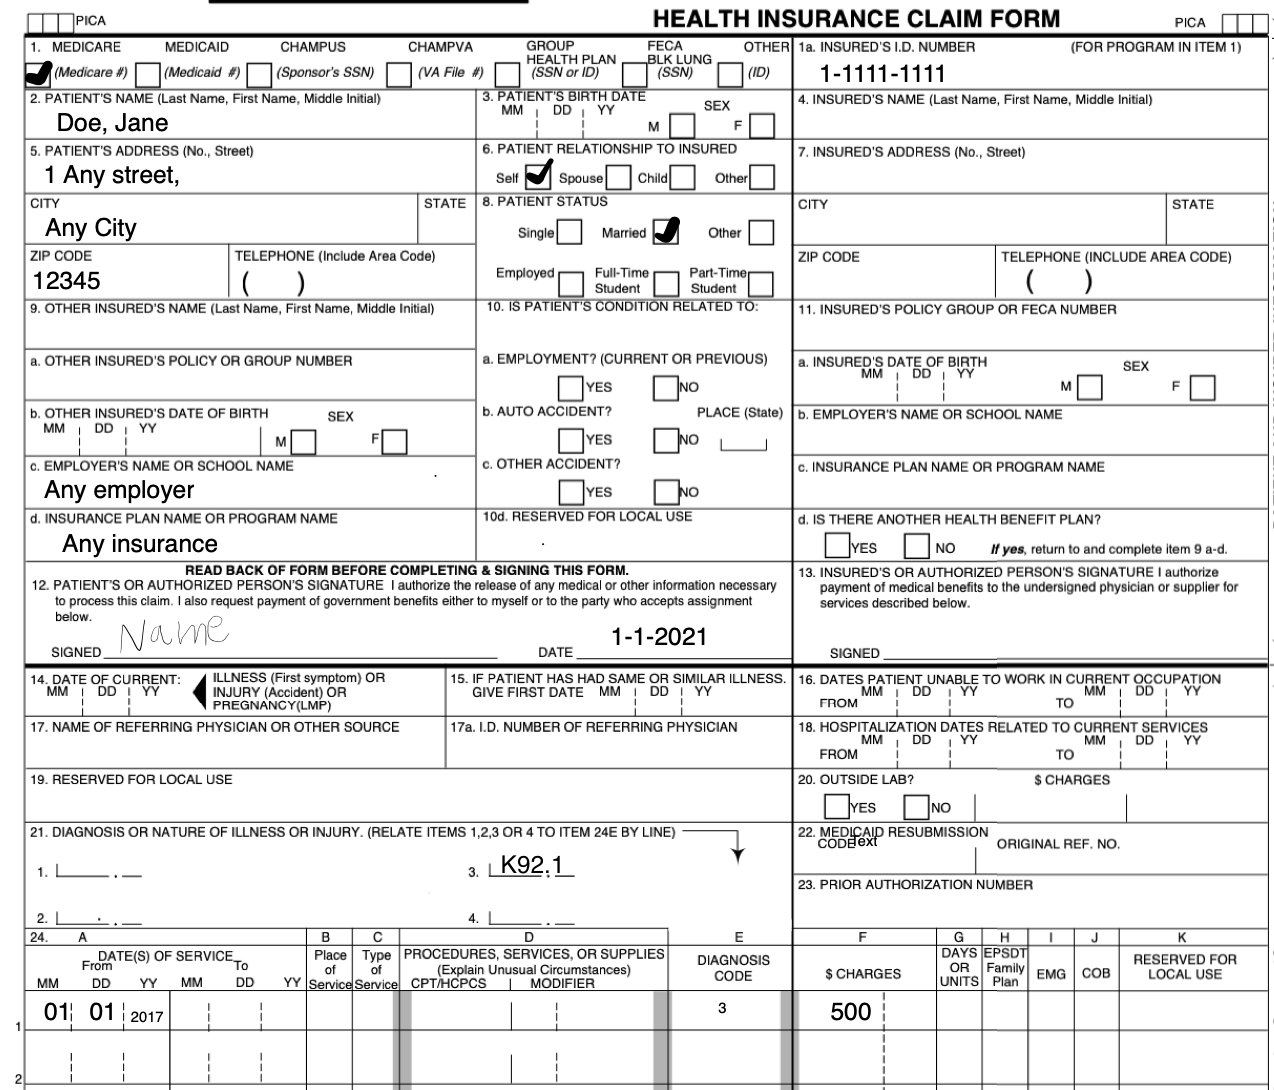

In [23]:
# Document

documentName = "cms1500-1.png"

display(Image(filename=documentName))

# Sample Document

30 fields. 2 fileds are optional [ local use, xxx]
member id field is a mandatory field

# Data Extraction

In [115]:
# process using image bytes
def calltextract(documentName): 
    client = boto3.client(service_name='textract',
         region_name= 'us-east-1',
         endpoint_url='https://textract.us-east-1.amazonaws.com')

    with open(documentName, 'rb') as file:
            img_test = file.read()
            bytes_test = bytearray(img_test)
            print('Image loaded', documentName)

    # process using image bytes
    response = client.analyze_document(Document={'Bytes': bytes_test}, FeatureTypes=['FORMS'])

    return response

In [116]:
response= calltextract(documentName)
print(response)

Image loaded cms1500-1.png
{'DocumentMetadata': {'Pages': 1}, 'Blocks': [{'BlockType': 'PAGE', 'Geometry': {'BoundingBox': {'Width': 1.0, 'Height': 1.0, 'Left': 0.0, 'Top': 0.0}, 'Polygon': [{'X': 1.0477747264954452e-16, 'Y': 0.0}, {'X': 1.0, 'Y': 1.4313762283211146e-16}, {'X': 1.0, 'Y': 1.0}, {'X': 0.0, 'Y': 1.0}]}, 'Id': 'eeac9395-c209-43d6-b548-b4136437aa24', 'Relationships': [{'Type': 'CHILD', 'Ids': ['877adc5a-aee6-4333-9e41-e63ecdd997f9', '0a0306fe-454b-4e94-a274-1db8e8135f8e', 'a1bbe275-2dc8-4385-a8c0-c41e53ac405d', '1f15d1d3-4e0d-455f-a061-d00e9f99d00f', '38cf2718-e5ab-4f11-b948-57d90bc93009', '395b0495-5377-405f-a886-0aacaedb52cf', '8d4643e4-0678-4f17-ad35-9611ff3f8d83', '37a45d54-f16c-454f-9cc2-57cf50ac8059', '4dfd7f56-6f6d-47dd-b143-1771366f9707', '21ad8a5a-2a32-4947-8a05-e3aa898092ea', '811d8d9f-0963-46ae-81d6-43b6986bbd85', '42604e4f-c07d-4f7e-9ea2-f47dee8d1cde', 'e5dbb82e-71be-4c1d-87c2-703f934c5d02', '515021be-ebed-4458-802d-c1494732fed7', 'dcca6f8a-1416-4bce-b3f5-37e56e

In [117]:
#Extract key values
# Iterate over elements in the document
from trp import Document
def getformkeyvalue(response):
    doc = Document(response)
    
    key_map = {}
    for page in doc.pages:
        # Print fields
        for field in page.form.fields:
            if field is None or field.key is None or field.value is None:
                continue
        
            key_map[field.key.text] = field.value.text
    return key_map

In [118]:
get_form_keys = getformkeyvalue(response)
print(get_form_keys)

{'YES': 'NOT_SELECTED', 'NO': 'NOT_SELECTED', 'ZIP CODE': '12345', 'Full-Time Student': 'NOT_SELECTED', 'CITY': 'Any City', "5. PATIENT'S ADDRESS (No., Street)": '1 Any street,', 'Part-Time Student': 'NOT_SELECTED', "c. EMPLOYER'S NAME OR SCHOOL NAME": 'Any employer', "2. PATIENT'S NAME (Last Name, First Name, Middle Initial)": 'Doe, Jane', 'Other': 'NOT_SELECTED', 'Single': 'NOT_SELECTED', 'TELEPHONE (Include Area Code)': '( )', 'M': 'NOT_SELECTED', 'TELEPHONE (INCLUDE AREA CODE)': '( )', 'Self': 'SELECTED', 'Child': 'NOT_SELECTED', 'd. INSURANCE PLAN NAME OR PROGRAM NAME': 'Any insurance', 'Spouse': 'NOT_SELECTED', "(Sponsor's SSN)": 'NOT_SELECTED', 'DATE': '1-1-2021', '(Medicaid #)': 'NOT_SELECTED', 'F': 'NOT_SELECTED', 'Married': 'SELECTED', '(Medicare #)': 'SELECTED', '(ID)': 'NOT_SELECTED', '3.': 'K92.1', 'SIGNED': 'Name', 'FECA BLK LUNG (SSN)': 'NOT_SELECTED', "1a. INSURED'S I.D. NUMBER": '1-1111-1111', '(VA File #)': 'NOT_SELECTED'}


# Post processing - Check for completeness - Acceptance Process
Check for validation using business rules for all the details in the claims document is present.
Checking if claim Id is 12 digit and zip code is digit

Adjudication - checking for code
participation, expectation rule - prior auth details is present
Evaluation - patient benefits and provider details for what is covered
Determination - payment, partial, denial

In [119]:
def validate(body):
    json_acceptable_string = body.replace("'", "\"")
    
    json_data = json.loads(body)
    
    zip = json_data['ZIP CODE']
    
    id = json_data['1a. INSURED\'S I.D. NUMBER']
    
    diagnosiscode = json_data["3."]
    print(diagnosiscode)
    print(id)
    print(zip)
    if(not zip.strip().isdigit()):
        return False, id, diagnosiscode, "Zip code invalid"
    length = len(id.strip())
    if(length != 11):
        return False, id, diagnosiscode, "Invalid claim Id"
    return True, id, diagnosiscode, "Ok"

In [120]:
 # Validate 
textract_json= json.dumps(get_form_keys,indent=2)
res, formid, diagnosiscode, result = validate(textract_json)
print(result)
print(formid)

K92.1
1-1111-1111
12345
Ok
1-1111-1111


# Enrich with medical insights
Valid Medical Intake Form send to Comprehend medical to gain insights

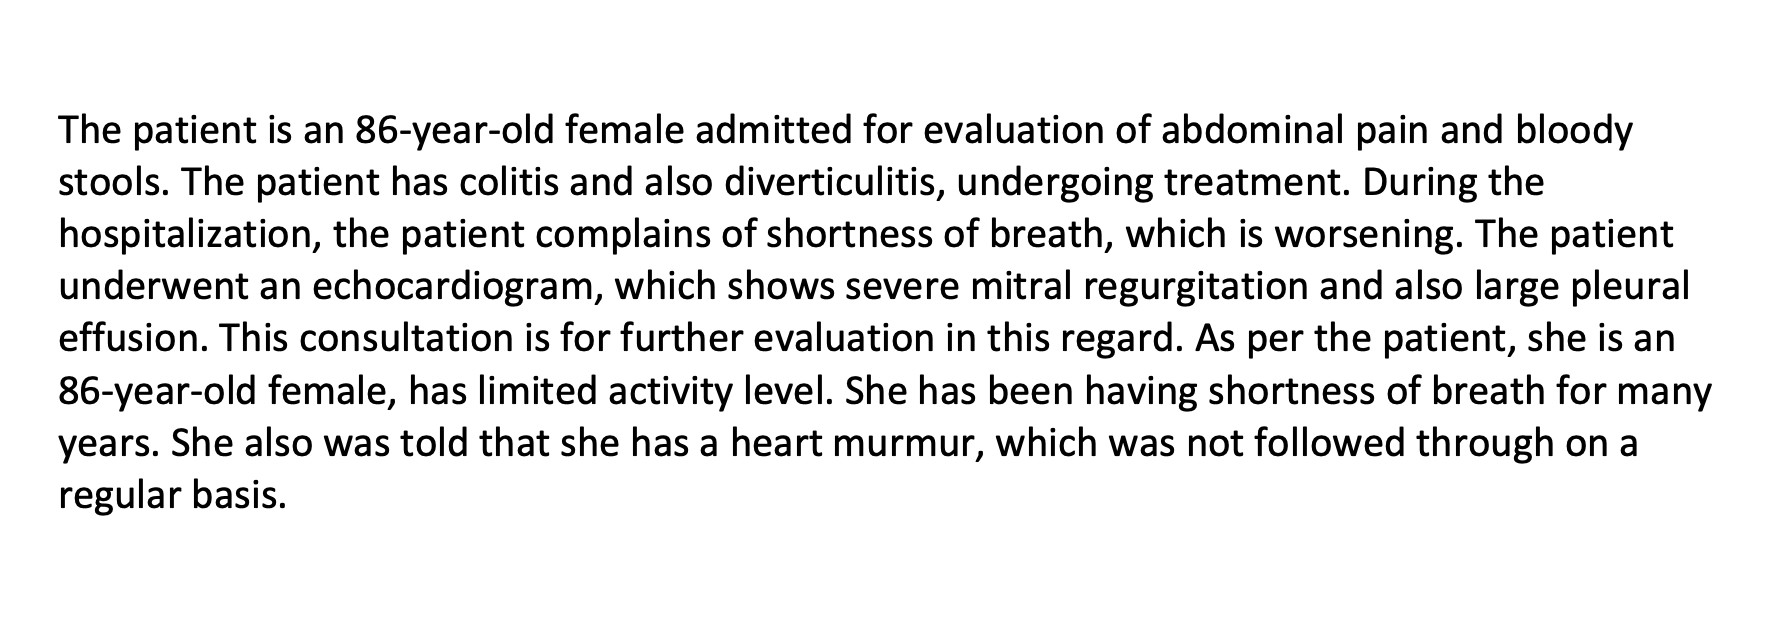

In [135]:
documentName = "doctornotes1.png"
display(Image(filename=documentName))



In [136]:
response= calltextract(documentName)
# Print text
print("\nText\n========")
text = ""
for item in response["Blocks"]:
    if item["BlockType"] == "LINE":
        print ('\033[94m' +  item["Text"] + '\033[0m')
        text = text + " " + item["Text"]

Image loaded doctornotes1.png

Text
The patient is an 86-year-old female admitted for evaluation of abdominal pain and
bloody
stools. The patient has colitis and also diverticulitis, undergoing treatment. During the
hospitalization, the patient complains of shortness of breath, which is worsening. The patient
underwent an echocardiogram, which shows severe mitral regurgitation and
also
large
pleural
effusion. This consultation is for further evaluation in this regard. As per the patient, she
is
an
86-year-old female, has limited activity level. She has been having shortness of breath for
many
years. She also was told that she has a heart murmur, which was not followed through
on
a
regular basis.



## Get Medical Insights

In [122]:
comprehend = boto3.client(service_name='comprehendmedical')
# Detect medical entities

cm_json_data =  comprehend.detect_entities_v2(Text=text)

print("\nMedical Entities\n========")
for entity in cm_json_data["Entities"]:
    print("- {}".format(entity["Text"]))
    print ("   Type: {}".format(entity["Type"]))
    print ("   Category: {}".format(entity["Category"]))
    if(entity["Traits"]):
        print("   Traits:")
        for trait in entity["Traits"]:
            print ("    - {}".format(trait["Name"]))
    print("\n")


Medical Entities
- 86
   Type: AGE
   Category: PROTECTED_HEALTH_INFORMATION


- abdominal pain
   Type: DX_NAME
   Category: MEDICAL_CONDITION
   Traits:
    - SYMPTOM


- bloody stools
   Type: DX_NAME
   Category: MEDICAL_CONDITION
   Traits:
    - SYMPTOM


- colitis
   Type: DX_NAME
   Category: MEDICAL_CONDITION
   Traits:
    - DIAGNOSIS


- diverticulitis
   Type: DX_NAME
   Category: MEDICAL_CONDITION
   Traits:
    - DIAGNOSIS


- shortness of breath
   Type: DX_NAME
   Category: MEDICAL_CONDITION
   Traits:
    - SYMPTOM


- echocardiogram
   Type: TEST_NAME
   Category: TEST_TREATMENT_PROCEDURE


- mitral regurgitation
   Type: DX_NAME
   Category: MEDICAL_CONDITION
   Traits:
    - DIAGNOSIS


- pleural effusion
   Type: DX_NAME
   Category: MEDICAL_CONDITION
   Traits:
    - DIAGNOSIS


- 86
   Type: AGE
   Category: PROTECTED_HEALTH_INFORMATION


- limited activity level
   Type: DX_NAME
   Category: MEDICAL_CONDITION
   Traits:
    - SYMPTOM


- shortness of breath
   

In [123]:
cm_json_data =  comprehend.infer_icd10_cm(Text=text)

print("\n Medical coding\n========")

for entity in cm_json_data["Entities"]:
    
    for icd in entity["ICD10CMConcepts"]:
        
        if (icd["Score"] >= 0.93):
            code = icd["Code"]
            print(code)
            



 Medical coding
K92.1


## Post Processing - Compare the dignosis code from the RAW doctor's notes

In [124]:
print("diagnosis code from claim form", diagnosiscode)
print("diagnosis code from raw doctor's note", code)

diagnosis code from claim form K92.1
diagnosis code from raw doctor's note K92.1


Writing entities to CSV File

# Invalid Claim

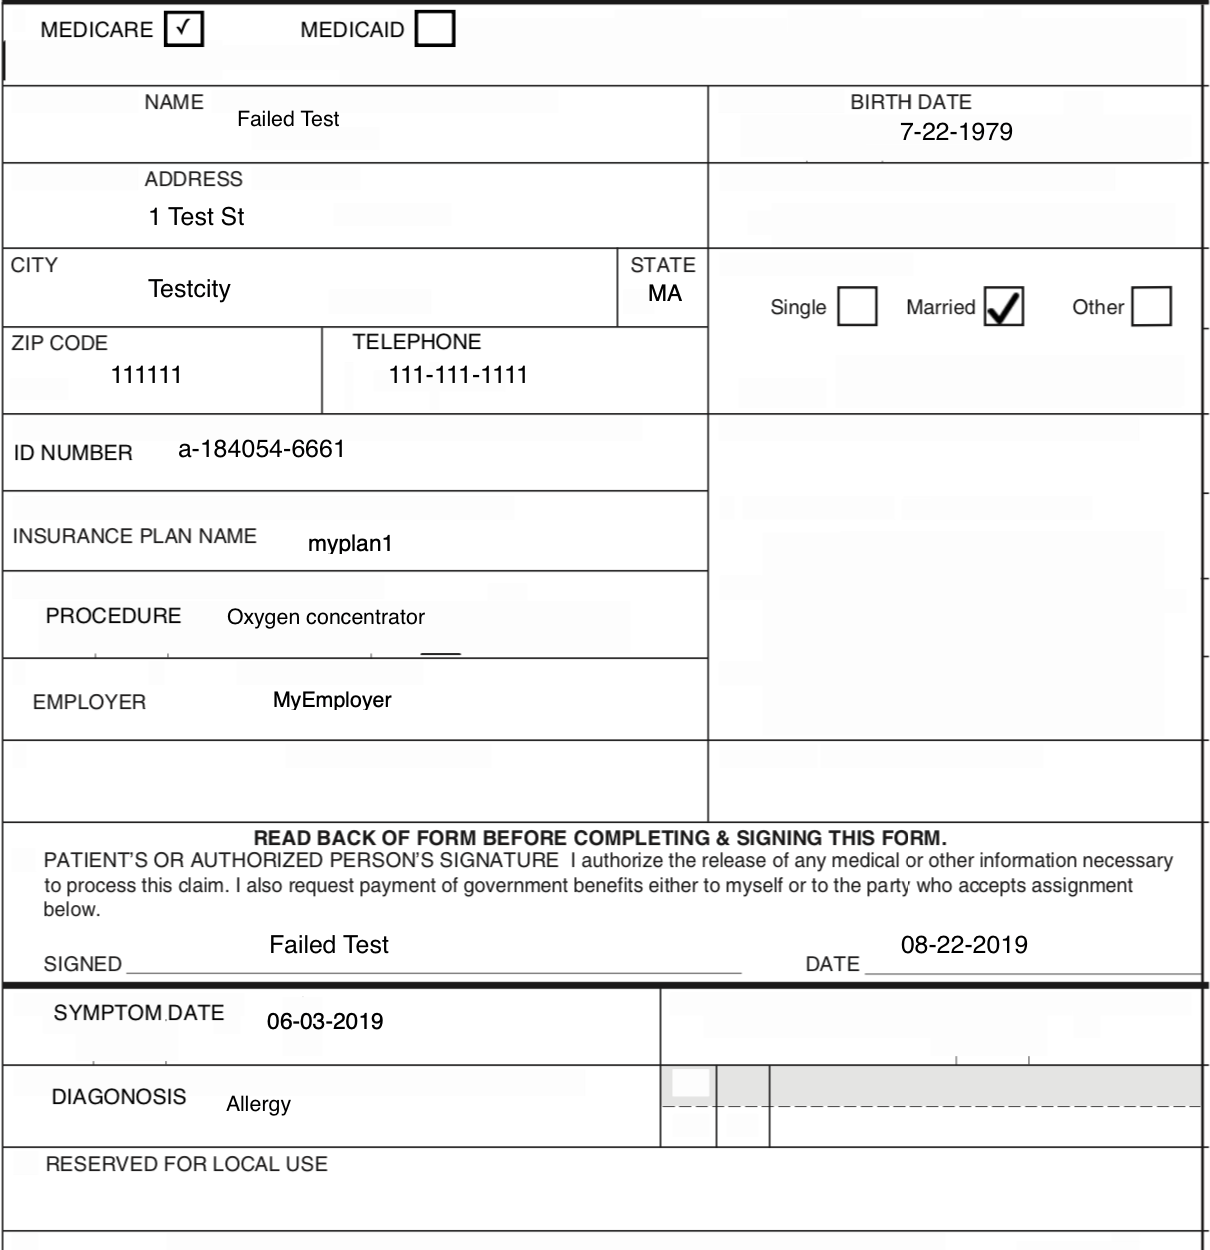

In [126]:
InvalidDocument = "failedtest.png"

display(Image(filename=InvalidDocument))

In [127]:
response = calltextract(InvalidDocument)

Image loaded failedtest.png


In [128]:
get_form_keys = getformkeyvalue(response)
print(get_form_keys)

{'Married': 'SELECTED', 'Other': 'NOT_SELECTED', 'MEDICAID': 'NOT_SELECTED', 'Single': 'NOT_SELECTED', 'TELEPHONE': '111-111-1111', 'ZIP CODE': '111111', 'STATE': 'MA', 'INSURANCE PLAN NAME': 'myplan1', 'ID NUMBER': 'a-184054-6661', 'ADDRESS': '1 Test St', 'NAME': 'Failed Test', 'DATE': '08-22-2019', 'SIGNED': 'Failed Test', 'MEDICARE': 'SELECTED', 'DIAGONOSIS': 'Allergy', 'BIRTH DATE': '7-22-1979', 'CITY': 'Testcity', 'SYMPTOMDATE': '06-03-2019', 'PROCEDURE': 'Oxygen concentrator', 'EMPLOYER': 'MyEmployer'}


In [133]:
 #In Validate 
textract_json= json.dumps(get_form_keys,indent=2)
json_data = json.loads(textract_json)

id = json_data['ID NUMBER']
print(id)

length = len(id.strip())
if(length != 11):
    print("Invalid claim Id")


a-184054-6661
Invalid claim Id


Delete the Amazon s3 bucket and the files in the buckethttps://docs.aws.amazon.com/AmazonS3/latest/userguide/delete-bucket.html